In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import researchpy as rp
import scipy.stats as stats
from sklearn.cluster import DBSCAN

import geopandas as gpd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

import matplotlib as mpl

import warnings
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
pd.options.display.max_rows = 4000
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Import local class
from apply_brf import SplitTrainAndPredict

In [2]:
## Define your path
PATH = r"D:\francisco_madrigal\Desktop\Tesis\modelo"

def create_path(file_path, path=PATH):
    
    return os.path.join(path, file_path)

In [3]:
## Open dictionary of crimes
crime_cat_file = open(create_path("crime_cat_dict.pkl"), "rb")
crime_cat_dict = pickle.load(crime_cat_file)

In [4]:
## Read neighborhoods DataFrame for later use
colonias = gpd.read_file(create_path(r"colonias_fixed\colonias_fixed.shp"))

## Declare the used coordinate system
colonias.crs = "epsg:4326"

## Print Coordinate Reference System (CRS)
# This is importan to homologue all crs from other georeferenced DataFrames
colonias.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ver https://imbalanced-learn.org/stable/index.html

## Data Transformation

In [5]:
## Read DataFrame
matrix_crimes = pd.read_csv(create_path("base_crimenes.csv"),
                            parse_dates =['Hora'])

## Create dummies
#matrix_crimes = pd.get_dummies(matrix_crimes, columns=['id_colonia', 'day_period', 'dia_semana', 'month'],
#                               prefix=["colonia", "day_per", "weekday", "month"], sparse=True)
            

## Show the balance of crimes DataFrame
matrix_crimes.value_counts(subset=["crimen"], normalize=True).to_frame('Relative').merge(
    
    matrix_crimes.value_counts(subset=["crimen"]).to_frame('Absolute'),
    on='crimen')

,Relative,Absolute
crimen,,
0,0.985901,13576405
1,0.014099,194150


In [6]:
## Merge to locate the Municipality for each nieghborhood
matrix_crimes = matrix_crimes.merge(colonias[['id_colonia', 'alcaldi']],
                                   how='left',
                                   on='id_colonia')

## Create an empty DataFrame to save the predictions for each municipality
results_brf = pd.DataFrame({})

## Create an empty DataFrame to save all scores of applied models
all_scores = pd.DataFrame({})

## Create an empty DataFrame to save tran-test-split results
train_test_table = pd.DataFrame({})

In [7]:
matrix_crimes

,Hora,id_colonia,day_period,day,month,year,Coordinates,categoria_delito,crimen,dia_semana,indice,past_near_crimes_500mts,pay_day,no_labor_day,past_crimes,TEMP,PRCP,CO,O3,PM10,covid_dummy,area_km2,metro,metrobus,rtp,supers_minisupers,department_stores,banks,corporate_offices,restaurants,g_edu,no_healt_s,pop_per_km2,house_per_km2,alcaldi
0,2017-01-16 00:00:00,1,0,16,1,2017,NaN,NaN,0,0,61,0,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
1,2017-01-16 06:00:00,1,1,16,1,2017,NaN,NaN,0,0,62,0,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
2,2017-01-16 12:00:00,1,2,16,1,2017,NaN,NaN,0,0,63,0,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
3,2017-01-16 18:00:00,1,3,16,1,2017,NaN,NaN,0,0,64,0,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
4,2017-01-17 00:00:00,1,0,17,1,2017,NaN,NaN,0,1,65,1,0,0,0.0,60.65,0.0,0.760863,35.344061,45.331019,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13770550,2022-03-29 18:00:00,1814,3,29,3,2022,NaN,NaN,0,1,13879256,5,0,0,0.0,70.50,0.0,0.435759,53.043651,58.445370,0,0.048810,0,0,1,0.0,0.0,1.0,0.0,0.0,12.845448,0.299020,29256.254756,10653.538146,VENUSTIANO CARRANZA
13770551,2022-03-30 00:00:00,1814,0,30,3,2022,NaN,NaN,0,2,13879257,5,0,0,0.0,73.95,0.0,0.389300,44.409722,54.773148,0,0.048810,0,0,1,0.0,0.0,1.0,0.0,0.0,12.845448,0.299020,29256.254756,10653.538146,VENUSTIANO CARRANZA
13770552,2022-03-30 06:00:00,1814,1,30,3,2022,NaN,NaN,0,2,13879258,5,0,0,0.0,73.95,0.0,0.389300,44.409722,54.773148,0,0.048810,0,0,1,0.0,0.0,1.0,0.0,0.0,12.845448,0.299020,29256.254756,10653.538146,VENUSTIANO CARRANZA
13770553,2022-03-30 12:00:00,1814,2,30,3,2022,NaN,NaN,0,2,13879259,5,0,0,0.0,73.95,0.0,0.389300,44.409722,54.773148,0,0.048810,0,0,1,0.0,0.0,1.0,0.0,0.0,12.845448,0.299020,29256.254756,10653.538146,VENUSTIANO CARRANZA


### Apply Balanced Random Forest

----------------------------------------------------------------------------------------------------
|MIGUEL HIDALGO|


Total features:  134
Observations:  637825


***TRAIN TABLE***
   Relative  Absolute
0  0.979132    624515
1  0.020868     13310


***TEST TABLE***
   Relative  Absolute
0  0.988386     31317
1  0.011614       368
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.763



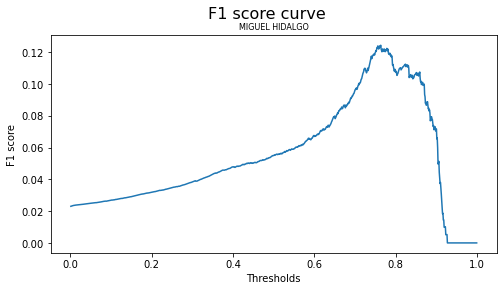

Results of Balanced Random Forest:

   F1 Score: 0.12432847275518033
   Accuracy: 0.9639892693703646
   Balanced Accuracy: 0.5964195807666623
   Average Precision Score: 0.04665565672801924


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     31317
           1       0.09      0.22      0.12       368

    accuracy                           0.96     31685
   macro avg       0.54      0.60      0.55     31685
weighted avg       0.98      0.96      0.97     31685

***************************


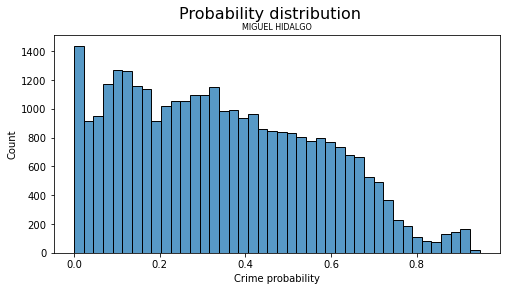

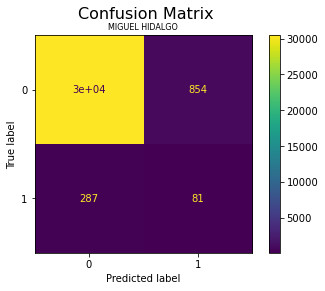

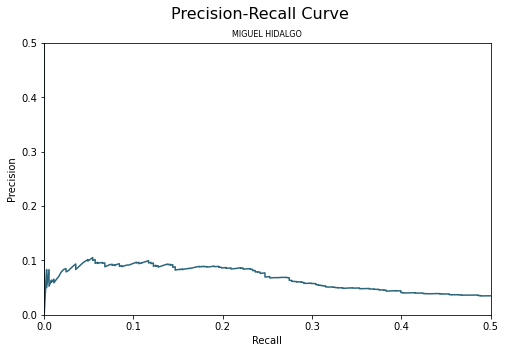

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|COYOACAN|


Total features:  200
Observations:  1115182


***TRAIN TABLE***
   Relative  Absolute
0  0.990592   1104690
1  0.009408     10492


***TEST TABLE***
   Relative  Absolute
0  0.993687     55091
1  0.006313       350
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.893



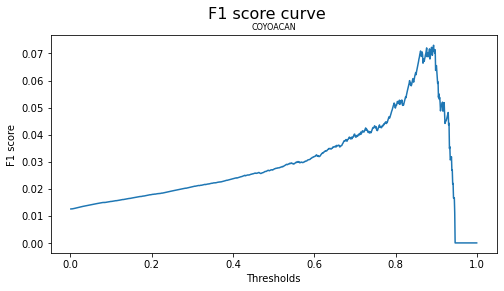

Results of Balanced Random Forest:

   F1 Score: 0.07303370786516854
   Accuracy: 0.9880954528237225
   Balanced Accuracy: 0.5340933572245401
   Average Precision Score: 0.028038067865746887


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     55091
           1       0.07      0.07      0.07       350

    accuracy                           0.99     55441
   macro avg       0.53      0.53      0.53     55441
weighted avg       0.99      0.99      0.99     55441

***************************


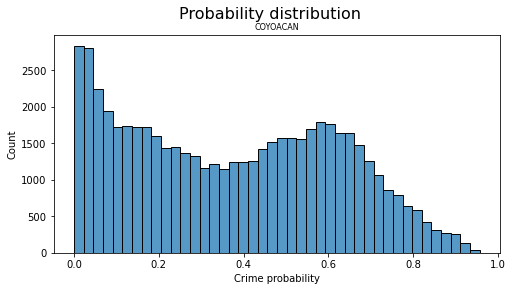

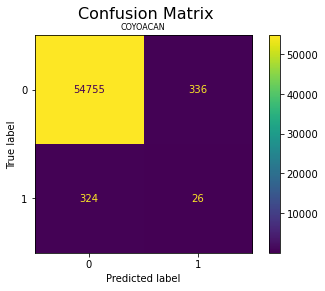

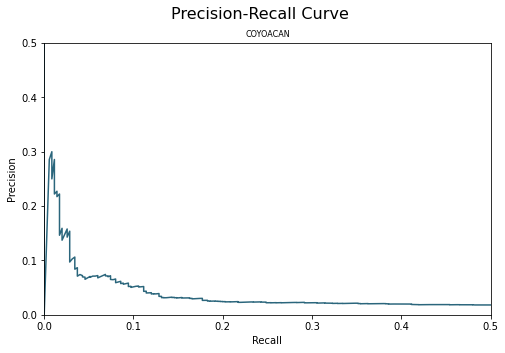

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|VENUSTIANO CARRANZA|


Total features:  127
Observations:  586864


***TRAIN TABLE***
   Relative  Absolute
0  0.979377    574761
1  0.020623     12103


***TEST TABLE***
   Relative  Absolute
0  0.986524     28771
1  0.013476       393
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.764



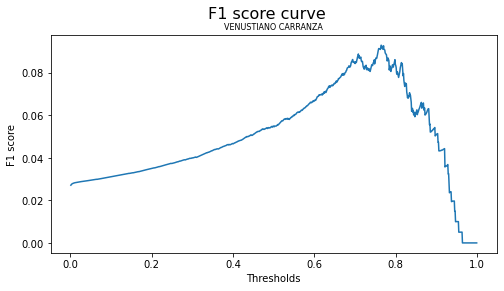

Results of Balanced Random Forest:

   F1 Score: 0.09297052154195011
   Accuracy: 0.9451378411740502
   Balanced Accuracy: 0.581924670931811
   Average Precision Score: 0.04943405406214984


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     28771
           1       0.06      0.21      0.09       393

    accuracy                           0.95     29164
   macro avg       0.52      0.58      0.53     29164
weighted avg       0.98      0.95      0.96     29164

***************************


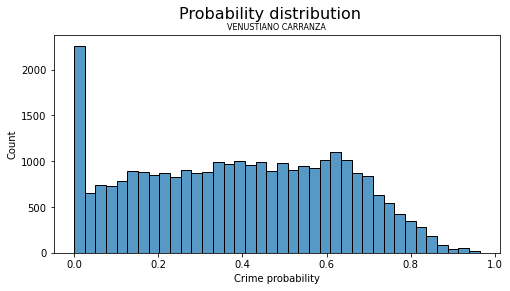

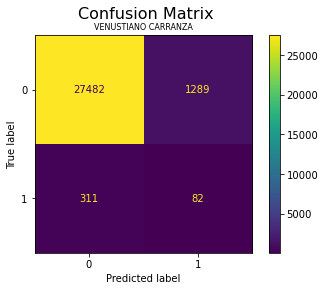

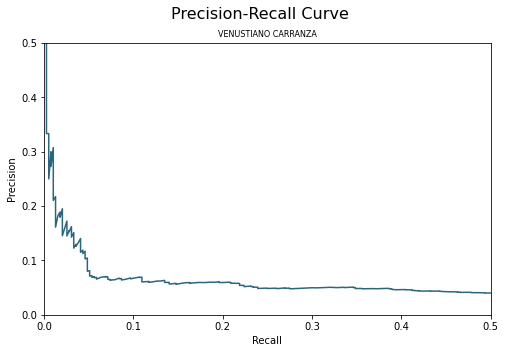

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|LA MAGDALENA CONTRERAS|


Total features:  98
Observations:  376495


***TRAIN TABLE***
   Relative  Absolute
0  0.994252    374331
1  0.005748      2164


***TEST TABLE***
   Relative  Absolute
0  0.994925     18625
1  0.005075        95
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.884



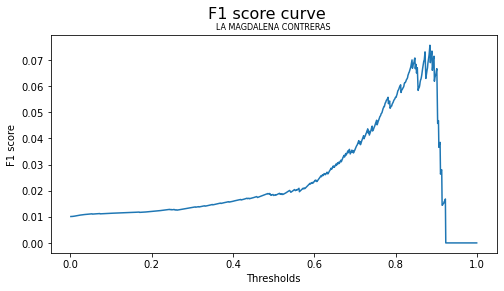

Results of Balanced Random Forest:

   F1 Score: 0.07563025210084036
   Accuracy: 0.9882478632478633
   Balanced Accuracy: 0.54377110561639
   Average Precision Score: 0.019665748053951406


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18625
           1       0.06      0.09      0.08        95

    accuracy                           0.99     18720
   macro avg       0.53      0.54      0.53     18720
weighted avg       0.99      0.99      0.99     18720

***************************


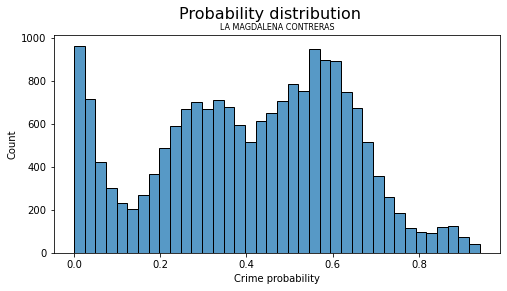

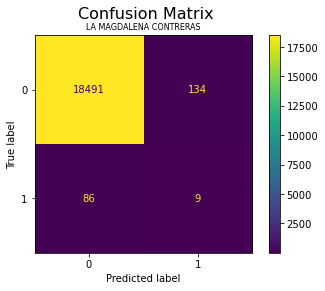

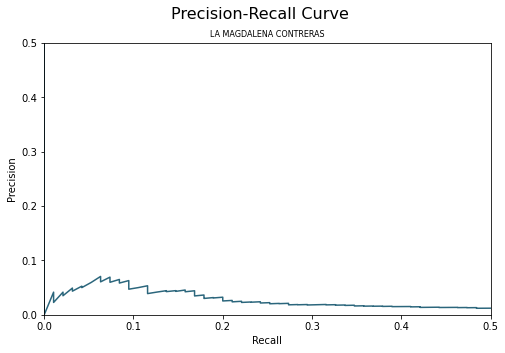

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|BENITO JUAREZ|


Total features:  110
Observations:  463677


***TRAIN TABLE***
   Relative  Absolute
0   0.97583    452470
1   0.02417     11207


***TEST TABLE***
   Relative  Absolute
0  0.985724     22716
1  0.014276       329
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.613



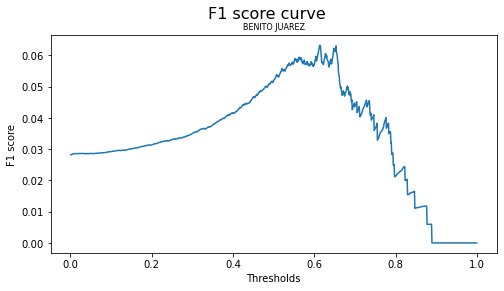

Results of Balanced Random Forest:

   F1 Score: 0.0632292058712834
   Accuracy: 0.8919939249294858
   Balanced Accuracy: 0.5782670757887401
   Average Precision Score: 0.029276020821887967


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     22716
           1       0.04      0.26      0.06       329

    accuracy                           0.89     23045
   macro avg       0.51      0.58      0.50     23045
weighted avg       0.97      0.89      0.93     23045

***************************


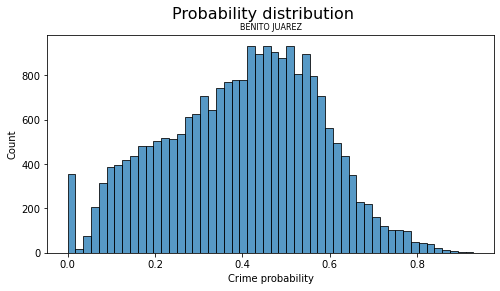

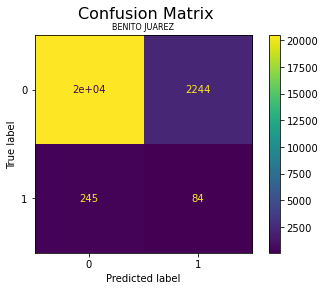

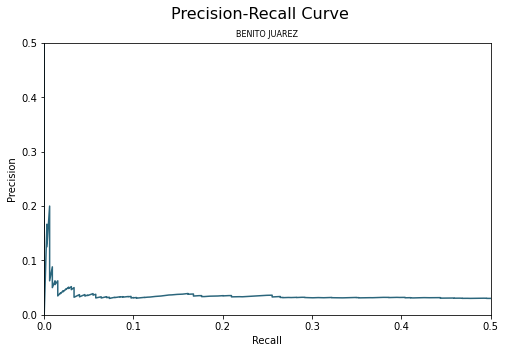

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|GUSTAVO A. MADERO|


Total features:  278
Observations:  1680123


***TRAIN TABLE***
   Relative  Absolute
0  0.987139   1658515
1  0.012861     21608


***TEST TABLE***
   Relative  Absolute
0  0.992051     82866
1  0.007949       664
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.796



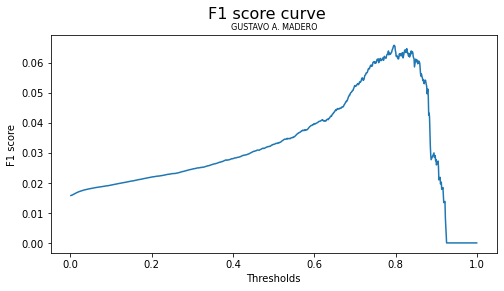

Results of Balanced Random Forest:

   F1 Score: 0.06583163413923682
   Accuracy: 0.9616066084041661
   Balanced Accuracy: 0.5690644883494589
   Average Precision Score: 0.026477739151039743


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     82866
           1       0.04      0.17      0.07       664

    accuracy                           0.96     83530
   macro avg       0.52      0.57      0.52     83530
weighted avg       0.99      0.96      0.97     83530

***************************


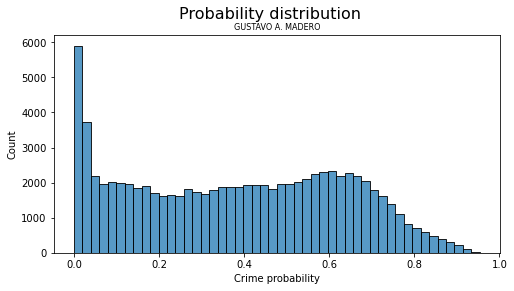

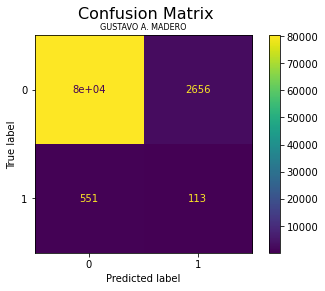

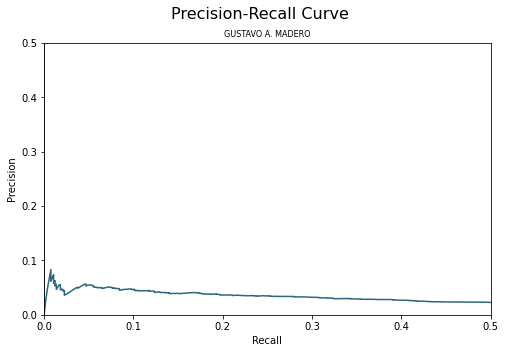

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|TLALPAN|


Total features:  223
Observations:  1281604


***TRAIN TABLE***
   Relative  Absolute
0   0.99284   1272428
1   0.00716      9176


***TEST TABLE***
   Relative  Absolute
0  0.994664     63382
1  0.005336       340
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.849



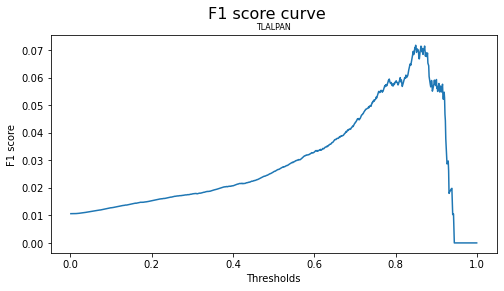

Results of Balanced Random Forest:

   F1 Score: 0.07172557172557173
   Accuracy: 0.9719720033897241
   Balanced Accuracy: 0.589519245582806
   Average Precision Score: 0.02521667687389072


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     63382
           1       0.04      0.20      0.07       340

    accuracy                           0.97     63722
   macro avg       0.52      0.59      0.53     63722
weighted avg       0.99      0.97      0.98     63722

***************************


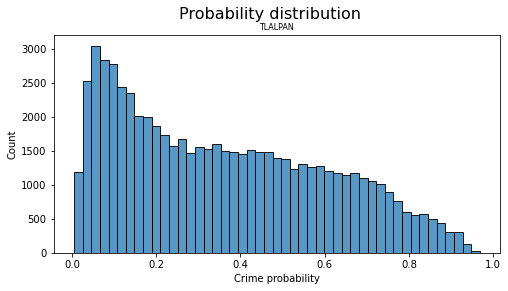

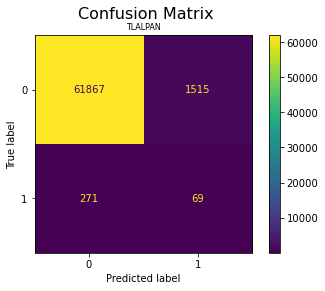

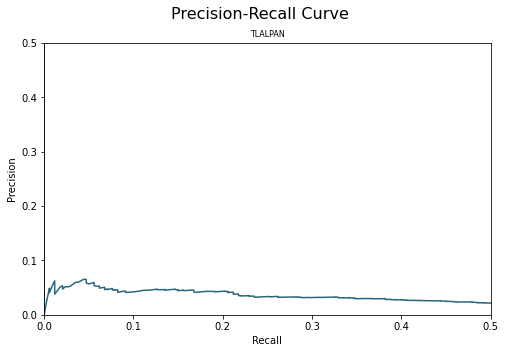

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|AZCAPOTZALCO|


Total features:  157
Observations:  803810


***TRAIN TABLE***
   Relative  Absolute
0  0.988329    794429
1  0.011671      9381


***TEST TABLE***
   Relative  Absolute
0  0.993119     39689
1  0.006881       275
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.813



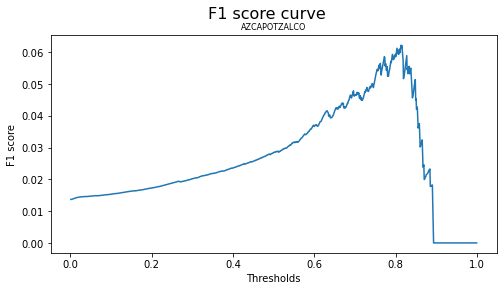

Results of Balanced Random Forest:

   F1 Score: 0.06216505894962487
   Accuracy: 0.9781052947652887
   Balanced Accuracy: 0.5448031627723734
   Average Precision Score: 0.022965176424908973


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     39689
           1       0.04      0.11      0.06       275

    accuracy                           0.98     39964
   macro avg       0.52      0.54      0.53     39964
weighted avg       0.99      0.98      0.98     39964

***************************


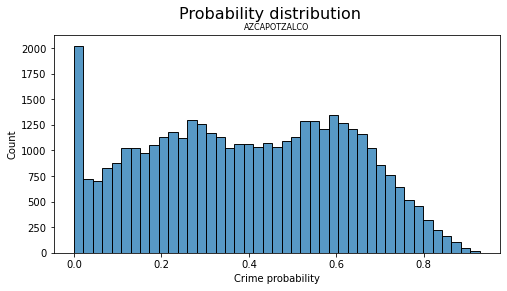

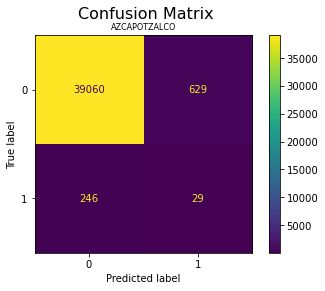

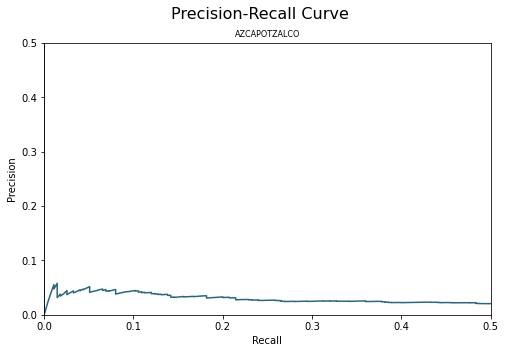

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|XOCHIMILCO|


Total features:  125
Observations:  572133


***TRAIN TABLE***
   Relative  Absolute
0  0.987859    565187
1  0.012141      6946


***TEST TABLE***
   Relative  Absolute
0  0.992617     28233
1  0.007383       210
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.857



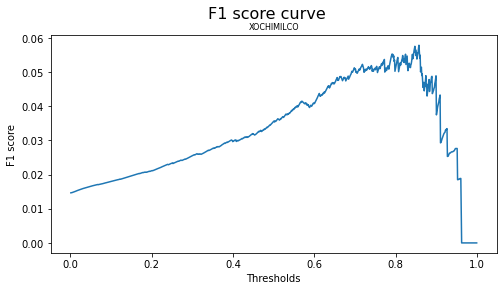

Results of Balanced Random Forest:

   F1 Score: 0.057887120115774245
   Accuracy: 0.9771121189747917
   Balanced Accuracy: 0.539454842610724
   Average Precision Score: 0.03627232540410055


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     28233
           1       0.04      0.10      0.06       210

    accuracy                           0.98     28443
   macro avg       0.52      0.54      0.52     28443
weighted avg       0.99      0.98      0.98     28443

***************************


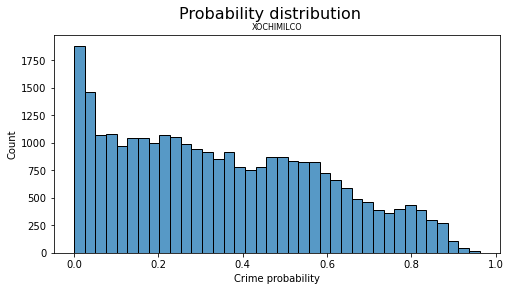

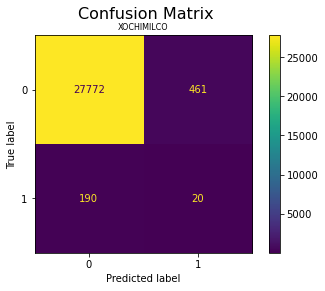

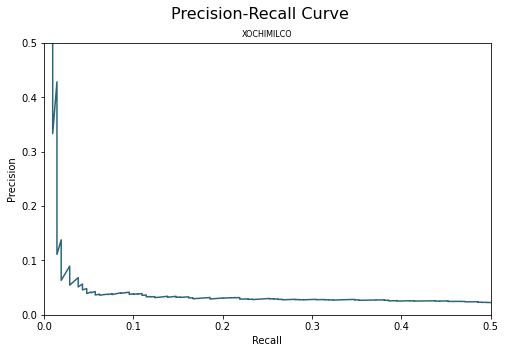

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|MILPA ALTA|


Total features:  57
Observations:  79656


***TRAIN TABLE***
   Relative  Absolute
0  0.989091     78787
1  0.010909       869


***TEST TABLE***
   Relative  Absolute
0  0.993687      3935
1  0.006313        25
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.869



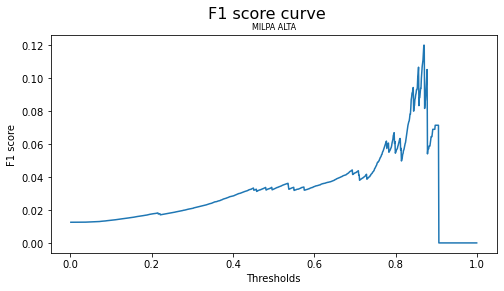

Results of Balanced Random Forest:

   F1 Score: 0.12
   Accuracy: 0.9888888888888889
   Balanced Accuracy: 0.5572045743329097
   Average Precision Score: 0.04800750332218351


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3935
           1       0.12      0.12      0.12        25

    accuracy                           0.99      3960
   macro avg       0.56      0.56      0.56      3960
weighted avg       0.99      0.99      0.99      3960

***************************


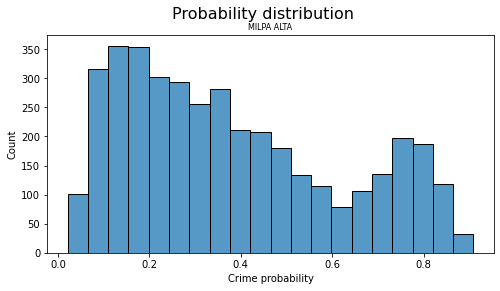

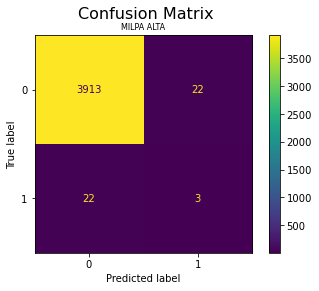

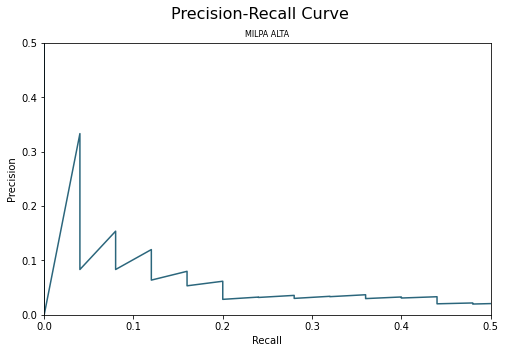

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|ALVARO OBREGON|


Total features:  296
Observations:  1810221


***TRAIN TABLE***
   Relative  Absolute
0    0.9931   1797730
1    0.0069     12491


***TEST TABLE***
   Relative  Absolute
0  0.995134     89568
1  0.004866       438
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.796



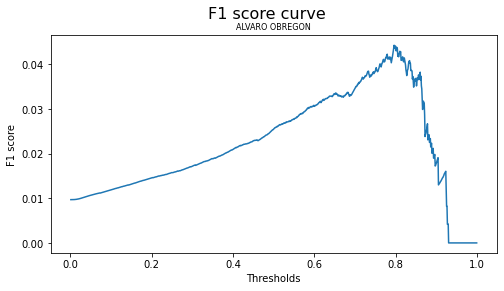

Results of Balanced Random Forest:

   F1 Score: 0.04425144747725393
   Accuracy: 0.9486478679199164
   Balanced Accuracy: 0.5981922512687995
   Average Precision Score: 0.017318092098808004


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     89568
           1       0.02      0.24      0.04       438

    accuracy                           0.95     90006
   macro avg       0.51      0.60      0.51     90006
weighted avg       0.99      0.95      0.97     90006

***************************


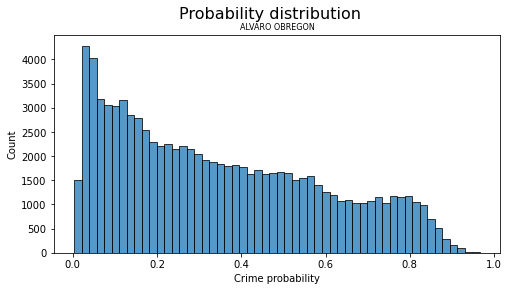

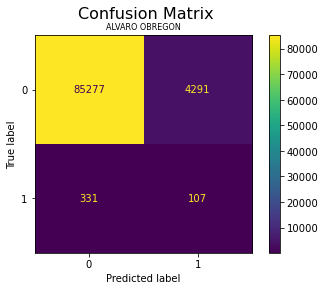

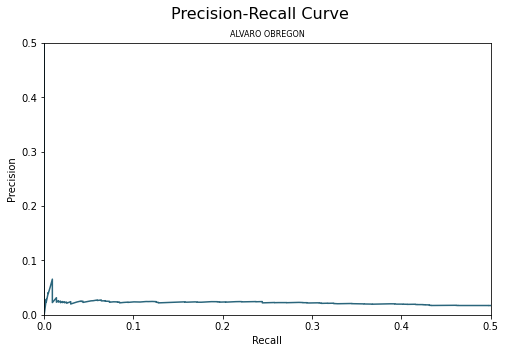

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|IZTACALCO|


Total features:  101
Observations:  398672


***TRAIN TABLE***
   Relative  Absolute
0  0.975456    388887
1  0.024544      9785


***TEST TABLE***
   Relative  Absolute
0  0.984094     19489
1  0.015906       315
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.761



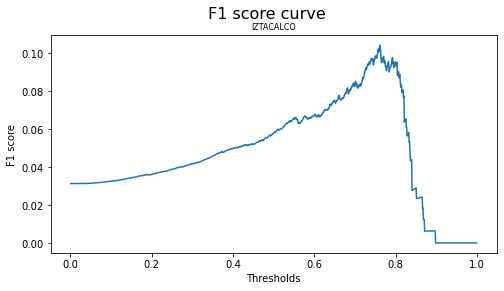

Results of Balanced Random Forest:

   F1 Score: 0.10427807486631016
   Accuracy: 0.9661684508180166
   Balanced Accuracy: 0.551796495703315
   Average Precision Score: 0.048926014670002314


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19489
           1       0.09      0.12      0.10       315

    accuracy                           0.97     19804
   macro avg       0.54      0.55      0.54     19804
weighted avg       0.97      0.97      0.97     19804

***************************


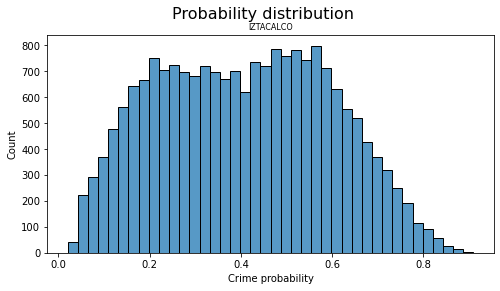

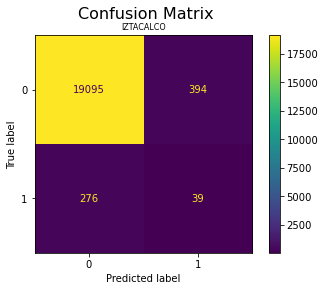

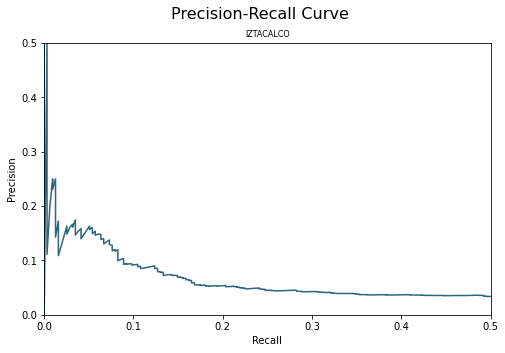

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|CUAUHTEMOC|


Total features:  109
Observations:  458607


***TRAIN TABLE***
   Relative  Absolute
0  0.946202    433935
1  0.053798     24672


***TEST TABLE***
   Relative  Absolute
0  0.973398     22101
1  0.026602       604
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.717



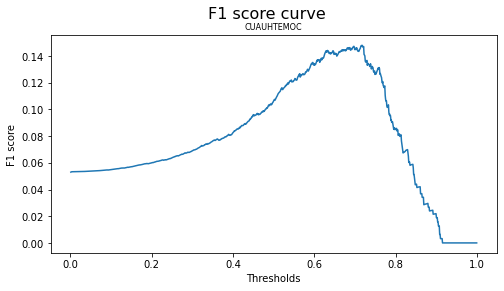

Results of Balanced Random Forest:

   F1 Score: 0.14814814814814814
   Accuracy: 0.9452983924245761
   Balanced Accuracy: 0.5725269091237069
   Average Precision Score: 0.0705563798311293


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     22101
           1       0.13      0.18      0.15       604

    accuracy                           0.95     22705
   macro avg       0.55      0.57      0.56     22705
weighted avg       0.95      0.95      0.95     22705

***************************


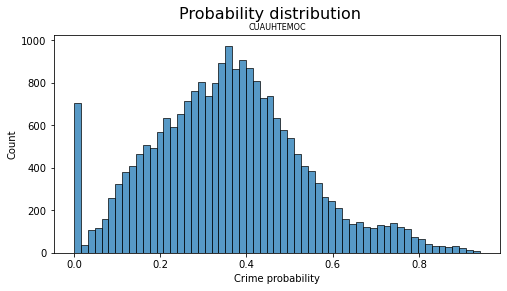

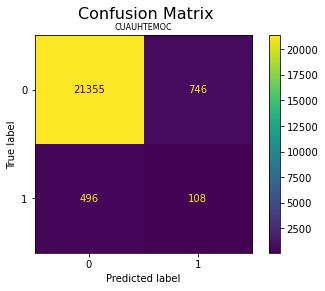

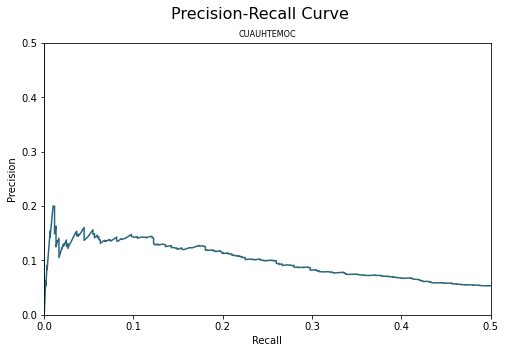

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|TLAHUAC|


Total features:  104
Observations:  420028


***TRAIN TABLE***
   Relative  Absolute
0  0.986708    414445
1  0.013292      5583


***TEST TABLE***
   Relative  Absolute
0   0.98918     20661
1   0.01082       226
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.819



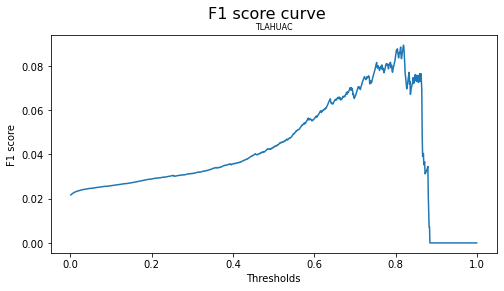

Results of Balanced Random Forest:

   F1 Score: 0.08939974457215837
   Accuracy: 0.9658639345047159
   Balanced Accuracy: 0.5648011323116144
   Average Precision Score: 0.036487784751875633


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     20661
           1       0.06      0.15      0.09       226

    accuracy                           0.97     20887
   macro avg       0.53      0.56      0.54     20887
weighted avg       0.98      0.97      0.97     20887

***************************


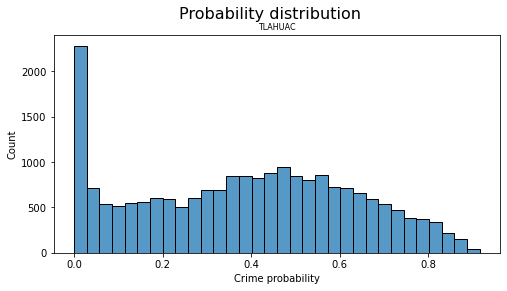

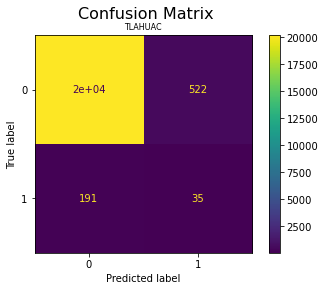

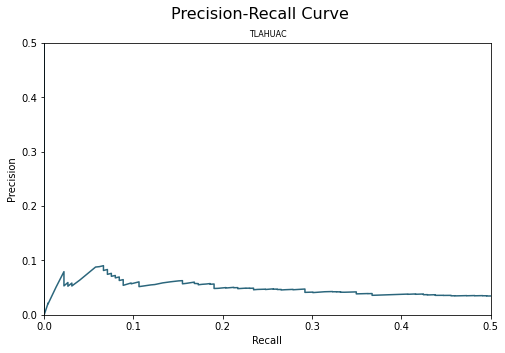

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|IZTAPALAPA|


Total features:  339
Observations:  2122273


***TRAIN TABLE***
   Relative  Absolute
0  0.982459   2085047
1  0.017541     37226


***TEST TABLE***
   Relative  Absolute
0  0.989052    104340
1  0.010948      1155
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.791



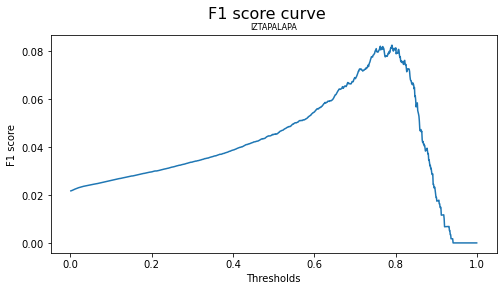

Results of Balanced Random Forest:

   F1 Score: 0.08243534482758622
   Accuracy: 0.9677141096734443
   Balanced Accuracy: 0.5547137355647994
   Average Precision Score: 0.038301650926531546


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    104340
           1       0.06      0.13      0.08      1155

    accuracy                           0.97    105495
   macro avg       0.53      0.55      0.53    105495
weighted avg       0.98      0.97      0.97    105495

***************************


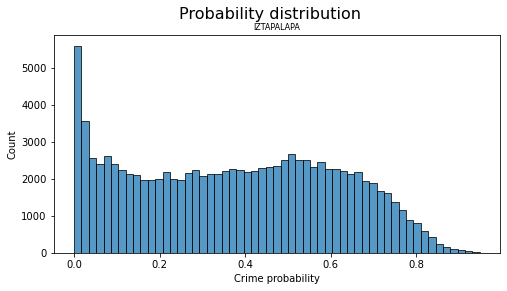

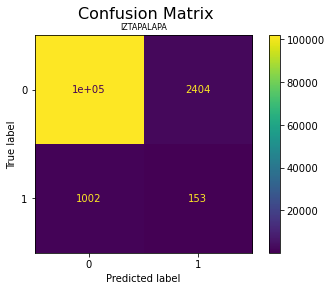

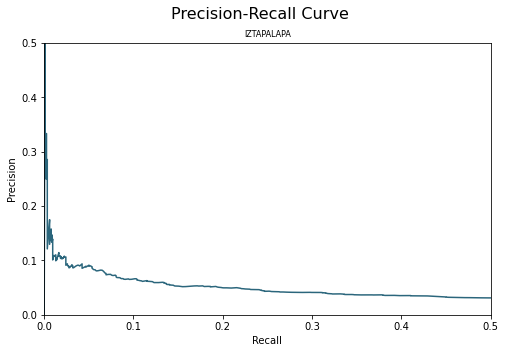

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|CUAJIMALPA DE MORELOS|


Total features:  89
Observations:  311334


***TRAIN TABLE***
   Relative  Absolute
0  0.995789    310023
1  0.004211      1311


***TEST TABLE***
   Relative  Absolute
0  0.997481     15441
1  0.002519        39
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.93



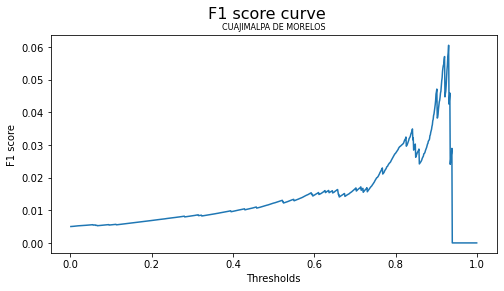

Results of Balanced Random Forest:

   F1 Score: 0.060606060606060615
   Accuracy: 0.9939922480620155
   Balanced Accuracy: 0.5366158030817055
   Average Precision Score: 0.01199153262078885


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15441
           1       0.05      0.08      0.06        39

    accuracy                           0.99     15480
   macro avg       0.52      0.54      0.53     15480
weighted avg       1.00      0.99      0.99     15480

***************************


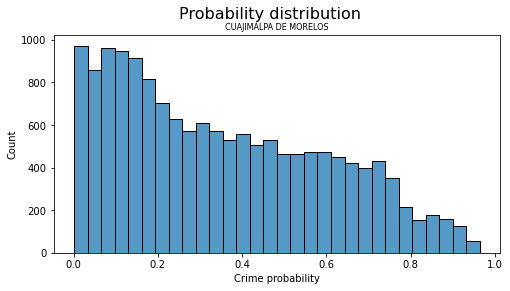

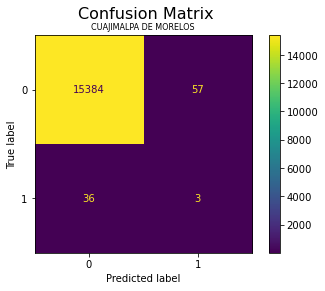

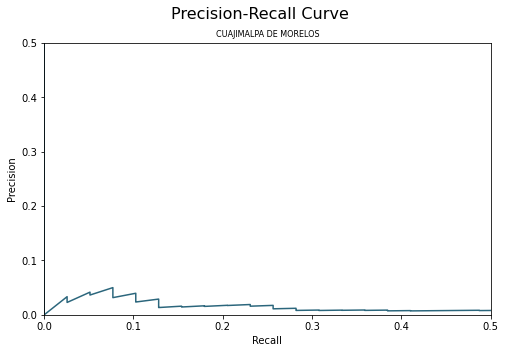

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [8]:
## Loop for every Alcaldia (Municipality) and apply the model
alcaldias_list = colonias['alcaldi'].unique()

for alcaldia in alcaldias_list:
    
    ## Initialize the class model
    model = SplitTrainAndPredict(alcaldi=alcaldia, copy_df=matrix_crimes, colonias=colonias)

    ## Create tran-test splits
    X_train, X_test, y_train, y_test, save_columns, ind_test = model.train_test_df()

    ## Apply the model
    brf, predictions, crime_prob, threshold = model.fit_my_results(X_train, X_test, y_train, y_test)

    ## Show and save scores
    save_scores_df = model.show_my_results(y_test, crime_prob, predictions, threshold, brf, save_columns)

    ## Predict
    local_crimes_test = model.predict_crimes(X_test, ind_test, crime_prob, predictions, save_columns)

    ## Concat results
    results_brf = pd.concat([results_brf, local_crimes_test], ignore_index=True)
    all_scores = pd.concat([all_scores, save_scores_df], ignore_index=True)
    train_test_table = pd.concat([train_test_table, model.train_test_table], ignore_index=True)

In [9]:
if not os.path.isdir(create_path(r"df_results")):
    
    os.makedirs(create_path(r"df_results"))

## Save DataFrames results
results_brf.to_csv(create_path(r"df_results\results_brf.csv"), index=False)

all_scores.to_csv(create_path(r"df_results\all_scores.csv"), index=False)

train_test_table.to_csv(create_path(r"df_results\train_test_table.csv"), index=False)

## Finally, save a reduced form of the results DataFrame and Neighborhoods
reduced_results_brf = results_brf[['id_colonia', 'day_period', 'dia_semana', 'proba_crimen']]

reduced_results_brf.to_csv(create_path(r"df_results\reduced_results_brf.csv"), index=False)

reduced_colonias = colonias[['id_colonia', 'colonia', 'geometry']].copy()

reduced_colonias.to_csv(create_path(r"df_results\reduced_colonias.csv"), index=False)

In [10]:
results_brf = pd.read_csv(create_path(r"df_results\results_brf.csv"),low_memory=False,
                          parse_dates=['Hora'])

results_brf['geometry'] = gpd.GeoSeries.from_wkt(results_brf['geometry'])

results_brf = gpd.GeoDataFrame(results_brf, geometry='geometry')

Results of Balanced Random Forest:

   F1 Score: 0.07584546781894952
   Accuracy: 0.9640840977162829
   Balanced Accuracy: 0.568119430497995
   Average Precision Score: 0.027229815207419995


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    646225
           1       0.05      0.16      0.08      5826

    accuracy                           0.96    652051
   macro avg       0.52      0.57      0.53    652051
weighted avg       0.98      0.96      0.97    652051

***************************


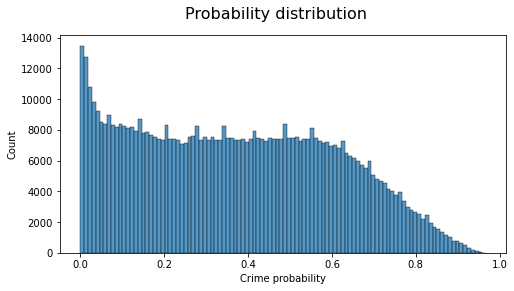

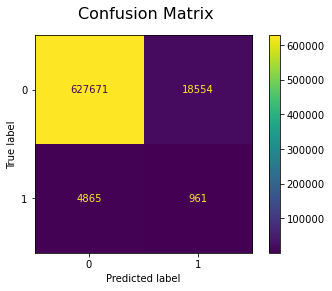

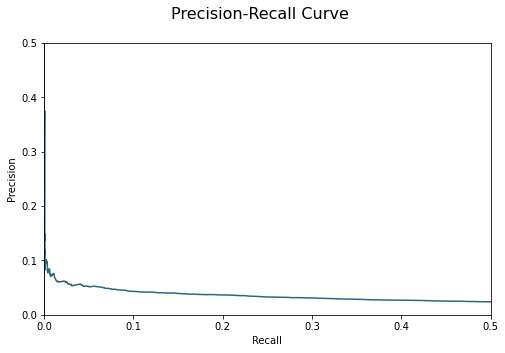

In [11]:
## Show aggregated results
model = SplitTrainAndPredict(copy_df=matrix_crimes, colonias=colonias, alcaldi="")


model.show_my_results(results_brf['crimen'], results_brf['proba_crimen'], results_brf['predictions'],
                      return_res_df=False)

### DBSCAN

We use DBSCAN to create clusters of crimes and hence reduce the spatial data. This will be help to have a better visual of the crime clusters locations. 

In [12]:
## Filter just crime observartions
crimes = matrix_crimes[matrix_crimes['crimen'] == 1].copy()

crimes['Coordinates'] = gpd.GeoSeries.from_wkt(crimes['Coordinates'])

crimes = gpd.GeoDataFrame(crimes, geometry='Coordinates')

## Create longitude and latitude series
crimes['lon'] = crimes['Coordinates'].apply(lambda p: p.x)
crimes['lat'] = crimes['Coordinates'].apply(lambda p: p.y)

## Filter just important columns
crimes = crimes[['lon','lat', 'categoria_delito']]

crimes['categoria_delito'].replace(crime_cat_dict,
                                   inplace=True)

In [13]:
## Transform to a numpyu array
coords = crimes[['lon','lat']].to_numpy()

## Establish epsilon to 50 meters
kms_per_radian = 6371.0088
epsilon = .05 / kms_per_radian

## Initiate DBSCAN
clt = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', metric='haversine')

## Fit
model = clt.fit(np.radians(coords))

cluster_labels = model.labels_

crimes['cluster'] = cluster_labels

num_clusters = len(set(cluster_labels))
print('Number of clusters: {:,}'.format(num_clusters))

non_cluster = len(crimes[crimes['cluster'] == -1])
cluster_points = len(crimes[crimes['cluster'] != -1])

clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

## Drop non clustered data points
crimes = crimes[crimes['cluster'] != -1]

print(f'Clustered points: {cluster_points}')
print(f'Non-Clustered points: {non_cluster}')

Number of clusters: 290
Clustered points: 55066
Non-Clustered points: 139084


In [14]:
## Save DataFram results
crimes.to_csv(create_path(r"df_results\cluster_crimes.csv"), index=False)

### Probability analysis

In [15]:
summary, results = rp.ttest(group1= results_brf['proba_crimen'][results_brf['crimen'] == 1], group1_name= "Crime",
                            group2= results_brf['proba_crimen'][results_brf['crimen'] == 0], group2_name= "Non-Crime")
print(summary)


    Variable         N      Mean        SD        SE  95% Conf.  Interval
0      Crime    5826.0  0.589410  0.192962  0.002528   0.584454  0.594365
1  Non-Crime  646225.0  0.369084  0.235159  0.000293   0.368510  0.369657
2   combined  652051.0  0.371052  0.235729  0.000292   0.370480  0.371624


In [16]:
print(results)

                  Independent t-test      results
0  Difference (Crime - Non-Crime) =        0.2203
1              Degrees of freedom =   652049.0000
2                               t =       71.2977
3           Two side test p value =        0.0000
4          Difference < 0 p value =        1.0000
5          Difference > 0 p value =        0.0000
6                       Cohen's d =        0.9383
7                       Hedge's g =        0.9383
8                   Glass's delta =        1.1418
9                     Pearson's r =        0.0880


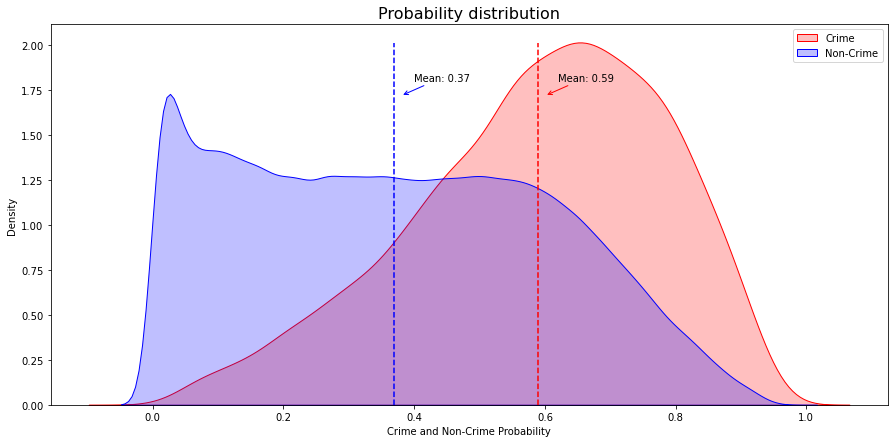

In [17]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 1], shade=True, ax=ax,
               color='red')
b = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 0], shade=True, ax=ax,
               color='blue')       

plt.title('Probability distribution', fontdict={'fontsize': 16})

plt.xlabel('Crime and Non-Crime Probability')

plt.ylabel('Density')
plt.legend(labels=['Crime','Non-Crime'])

ax.axvline(x=results_brf['proba_crimen'][results_brf['crimen'] == 1].mean(), ymax=0.95, linestyle='--', color='red')
plt.annotate(
    'Mean: ' + '{:,.2f}'.format(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean()),
    xy=(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean(), 1.7),
    xytext=(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean()+.03, 1.8),
    arrowprops=dict(arrowstyle='->', color='red', shrinkB=10))

ax.axvline(x=results_brf['proba_crimen'][results_brf['crimen'] == 0].mean(), ymax=0.95, linestyle='--', color='blue')

plt.annotate(
    'Mean: ' + '{:,.2f}'.format(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean()),
    xy=(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean(), 1.7),
    xytext=(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean()+.03, 1.8),
    arrowprops=dict(arrowstyle='->', color='blue', shrinkB=10))

plt.show()

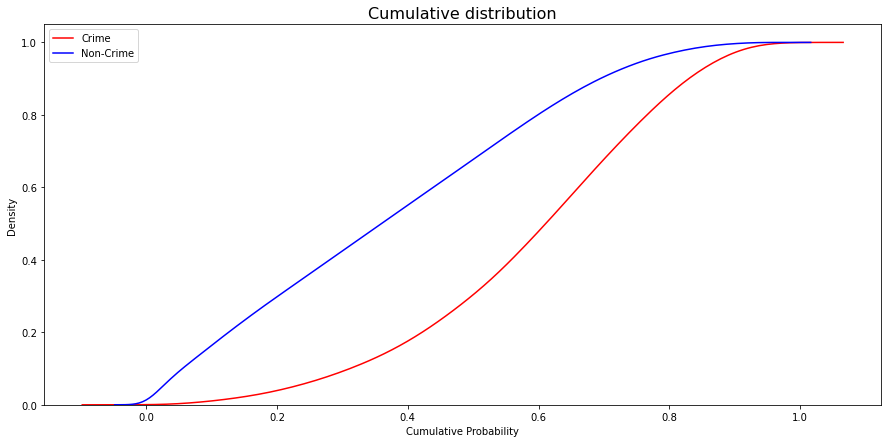

In [18]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 1], ax=ax,
               color='red', cumulative=True)
b = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 0], ax=ax,
               color='blue', cumulative=True)       

plt.title('Cumulative distribution', fontdict={'fontsize': 16})

plt.xlabel('Cumulative Probability')

plt.ylabel('Density')
plt.legend(labels=['Crime','Non-Crime'])

plt.show()

In [19]:
results_brf_agg = results_brf.groupby(['id_colonia', 'colonia']).agg({'proba_crimen':['mean', 'median', 'std'], 
                                                                      'predictions':'mean',
                                                                      'crimen':'mean'}).reset_index()

results_brf_agg.columns = ['_'.join(col).strip() for col in results_brf_agg.columns.values]


In [20]:
results_brf_agg.sort_values(by='proba_crimen_mean', ascending=False).head(10)

,id_colonia_,colonia_,proba_crimen_mean,proba_crimen_median,proba_crimen_std,predictions_mean,crimen_mean
725,726,SAN PEDRO CUAJIMALPA (PBLO),0.894286,0.8990,0.036541,0.166667,0.016667
659,660,TLALPAN CENTRO,0.892028,0.9070,0.044512,0.803324,0.038781
215,216,PASEOS DE CHURUBUSCO,0.876197,0.8860,0.038550,0.969529,0.096953
173,174,SAN MIGUEL TOPILEJO (PBLO),0.873283,0.8795,0.043742,0.736111,0.055556
584,585,SAN JERONIMO ACULCO - LIDICE (PBLO),0.868908,0.8720,0.038596,0.355556,0.030556
1712,1715,TIZAPAN_TIZAPAN SAN ANGEL,0.868036,0.8710,0.043194,0.933333,0.013889
496,497,DEL CARMEN,0.862449,0.8900,0.069751,0.454294,0.047091
33,34,SAN PEDRO MARTIR (PBLO),0.860703,0.8670,0.046726,0.597222,0.033333
849,850,TACUBA,0.860330,0.8910,0.067411,0.858726,0.083102
1790,1794,CAMPESTRE CHURUBUSCO,0.860319,0.8825,0.064740,0.369444,0.038889


In [21]:
results_brf.reset_index(level=0, inplace=True, drop=True)

results_brf_recall = results_brf[results_brf['crimen'] == 1].copy()

results_brf_recall = results_brf_recall.groupby(results_brf['Hora'].dt.date)[['predictions']].mean().reset_index()

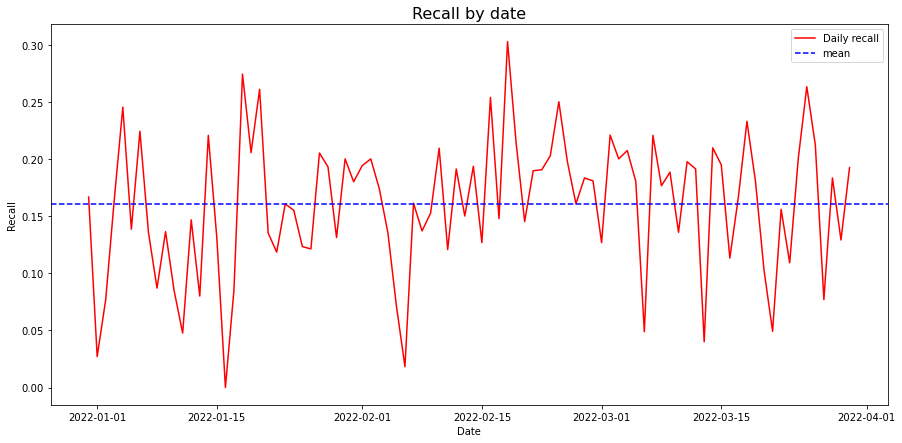

In [22]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.lineplot(data=results_brf_recall, y='predictions', x='Hora', ax=ax,
               color='red')

plt.title('Recall by date', fontdict={'fontsize': 16})

plt.xlabel('Date')

ax.axhline(y=results_brf_recall['predictions'].mean(), linestyle='--', color='blue')

plt.ylabel('Recall')
plt.legend(labels=['Daily recall', 'mean'])

plt.show()

In [23]:
results_brf_recall.groupby(results_brf['Hora'].dt.weekday)[['predictions']].mean().reset_index()

,Hora,predictions
0,0,0.163693
1,1,0.153897
2,2,0.180615
3,3,0.162626
4,4,0.162310
5,5,0.180229
6,6,0.114145


In [24]:
#https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/

#https://www.kaggle.com/prashant111/explain-your-model-predictions-with-shapley-values

#https://towardsdatascience.com/tagged/shapley-values

#https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html